# Dataset

In [1]:
from keras.datasets import mnist
import keras
import numpy as np

(X, y), (X_test, y_test) = mnist.load_data(path="mnist.npz")

In [2]:
X.shape, y.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
X = X.reshape((60000, 28*28))/255
X_test = X_test.reshape((10000, 28*28))/255
y_cat, y_test_cat = keras.utils.to_categorical(y, num_classes=10), keras.utils.to_categorical(y_test, num_classes=10)

In [4]:
y_mu = np.zeros((X.shape[0], 2))

# Model

In [5]:
from keras import layers, Model, Input, activations
from keras.optimizers import Adam
from keras import ops

In [6]:
# Encodeur
encodeur_input = Input(shape=(784, ))
label = Input(shape=(10, ))
encodeur_input_concat = layers.Concatenate()([encodeur_input, label])
x = layers.Dense(128, activation=activations.relu)(encodeur_input_concat)
x = layers.Dense(8, activation=activations.relu)(x)
mu = layers.Dense(2)(x)
logvar = layers.Dense(2)(x)
z = mu + keras.random.normal(shape = (1, ops.shape(mu)[1]))*ops.exp(0.5*logvar)
encodeur = Model([encodeur_input, label], z)

# Décodeur
decodeur_input = Input(shape=(2,))
decodeur_label = Input(shape=(10, ))
decodeur_input_concat = layers.Concatenate()([decodeur_input, decodeur_label])
x = layers.Dense(8, activation=activations.relu)(decodeur_input_concat)
x = layers.Dense(128, activation=activations.relu)(x)
decodeur_output = layers.Dense(784, activation="sigmoid")(x)
decodeur = Model([decodeur_input, decodeur_label], decodeur_output)

# Autoencodeur variationnel
autoencodeur_variationnel = Model(inputs = [encodeur_input, label],
                                  outputs = [decodeur([encodeur([encodeur_input, label]), label]), mu, ops.exp(logvar)-1, logvar])

In [7]:
autoencodeur_variationnel.compile(optimizer=Adam(learning_rate=0.001),
                                  loss=["mse", "mse", "mae", "mae"], loss_weights=[1000, 1, 1, 1])

In [8]:
history = autoencodeur_variationnel.fit([X, y_cat], [X, y_mu, y_mu, y_mu],
                              batch_size=256,
                              epochs=50,
                              validation_split=0.1)

Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - dense_2_loss: 0.6506 - dense_3_loss: 0.8353 - functional_1_loss: 0.0809 - loss: 84.8496 - subtract_loss: 2.4379 - val_dense_2_loss: 0.5115 - val_dense_3_loss: 0.1771 - val_functional_1_loss: 0.0581 - val_loss: 58.9533 - val_subtract_loss: 0.1946
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - dense_2_loss: 0.5967 - dense_3_loss: 0.1024 - functional_1_loss: 0.0514 - loss: 52.1829 - subtract_loss: 0.1134 - val_dense_2_loss: 0.4691 - val_dense_3_loss: 0.0831 - val_functional_1_loss: 0.0461 - val_loss: 46.6647 - val_subtract_loss: 0.0948
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - dense_2_loss: 0.5147 - dense_3_loss: 0.0718 - functional_1_loss: 0.0450 - loss: 45.6426 - subtract_loss: 0.0815 - val_dense_2_loss: 0.4544 - val_dense_3_loss: 0.0630 - val_functional_1_loss: 0.0429 - val_loss: 43.4592 - val_subtract_loss: 0.0738
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - dense_2_loss: 0.4894 - dense_3_loss: 0.0588 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


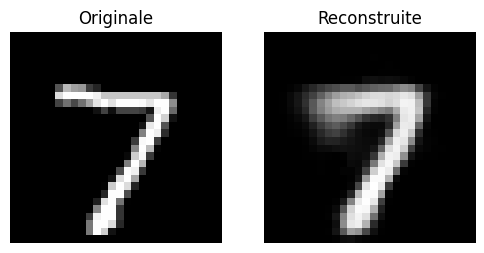

In [9]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

X_pred = autoencodeur_variationnel.predict([X_test, y_test_cat])[0]

for i in range (len(X_pred)) :
    plt.figure(figsize=(6,3))  # taille du canvas (largeur, hauteur)

    # Image originale
    plt.subplot(1, 2, 1)   # 1 ligne, 2 colonnes, 1er subplot
    plt.imshow(X_test[i].reshape((28, 28)), cmap="gray")
    plt.title("Originale")
    plt.axis("off")

    # Image reconstruite
    plt.subplot(1, 2, 2)   # 1 ligne, 2 colonnes, 2e subplot
    plt.imshow(X_pred[i].reshape((28, 28)), cmap="gray")
    plt.title("Reconstruite")
    plt.axis("off")

    plt.show()

    choix = input("Continuer ? (o/n) : ")

    if choix.lower() == "n":
        break

    clear_output(wait=True)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step


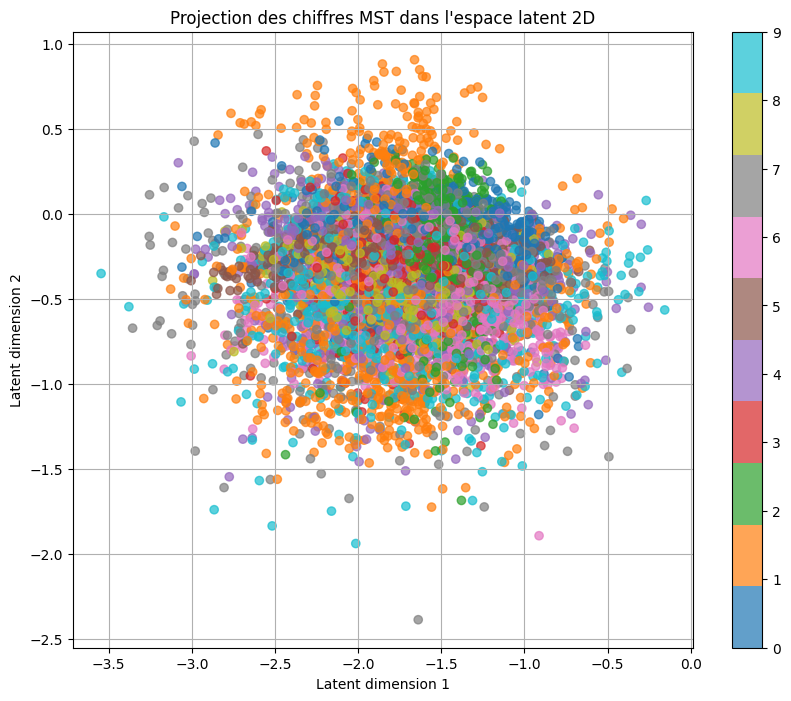

In [10]:
# 5. Encoder les données de test
X_test_latent = encodeur.predict([X_test, y_test_cat])

# 6. Scatter plot avec couleur selon les labels y_test
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("Projection des chiffres MST dans l'espace latent 2D")
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.grid(True)
plt.show()